# Classifying OUV using Pretrained BERT

## Imports

In [1]:
import sys
sys.executable

'/opt/miniconda3/bin/python'

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from torch.autograd import Variable

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import random

from scipy.special import softmax

import pickle
import matplotlib.pyplot as plt

from transformers import  BertTokenizer, BertModel, BertConfig

In [3]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.7.0
GPU-enabled installation? False


In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


## Data Vectorization Classes

### BERT Vectorizer and Dataset

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### The Vectorizer

In [6]:
class OuvVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, tokenizer):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
        """
        self.tokenizer = tokenizer
        
    def vectorize(self, data):
        """Create a collapsed one-hit vector for the ouv data
        
        Args:
            data (str): the ouv description data
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vectorized data (np.ndarray)
        """
        
        vector_length = args.max_length
                
        inputs = self.tokenizer.encode_plus(
            data,
            None,
            add_special_tokens=True,
            max_length = vector_length,
            pad_to_max_length = True,
            return_token_type_ids = True,
            truncation=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype = torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

### The Dataset

In [7]:
class OuvDataset(Dataset):
    def __init__(self, ouv_df, vectorizer):
        """
        Args:
            ouv_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.ouv_df = ouv_df
        self._vectorizer = vectorizer
        
        # +0 if not using begin_seq and end seq, +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, ouv_df.data)) + 2

        self.train_df = self.ouv_df[self.ouv_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.ouv_df[self.ouv_df.split=='dev']
        self.validation_size = len(self.val_df)

        self.test_df = self.ouv_df[self.ouv_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, ouv_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            ouv_csv (str): location of the dataset
            
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        train_ouv_df = ouv_df[ouv_df.split=='train']
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        vectorizer = OuvVectorizer(tokenizer)
        return cls(ouv_df, vectorizer)
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, ouv_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            ouv_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of OuvDataset
        """
        ouv_df = pd.read_csv(ouv_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(ouv_df, vectorizer)

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.tokenizer.vocab, fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and component for labels (y_target and y_fuzzy)
        """
        row = self._target_df.iloc[index]
        
        tokenized = self._vectorizer.vectorize(row.data)
        ouv_vector = tokenized['ids']
        mask = tokenized['mask']
        token_type_ids = tokenized['token_type_ids']

        true_label = \
            np.fromstring(row.true[1:-1],dtype=float, sep=' ')
        
        if len(true_label)==10:
            true_label = np.append(true_label,0.0)
        
        fuzzy_label = \
            np.fromstring(row.fuzzy[1:-1],dtype=float, sep=' ')

        return {'x_data': ouv_vector,
                'y_target': true_label,
                'y_fuzzy': fuzzy_label,
                'mask': mask,
                'token_type_ids': token_type_ids,
                #'text' : row.data,
                'id' : row.id
               }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: BERT Model

In [8]:
class BERTClassifier(nn.Module):
    
    def __init__(self, num_classes, dropout_p):
        """
        Args:
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            
        """
        super(BERTClassifier, self).__init__()

        self._dropout_p = dropout_p
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',output_attentions=True)
        #for param in self.bert.parameters():
        #    param.requires_grad = False        
        self.fc = nn.Linear(768, num_classes)

    def forward(self, ids, mask, token_type_ids, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        model_outs = self.bert(ids,attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = model_outs[1]
        y_out = self.fc(F.dropout(output_1, self._dropout_p, self.training))
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out, model_outs

## Training Routine

### Helper Functions

In [9]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_1_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_1_acc': [],
            'train_k_acc': [],
            'train_k_jac': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_k_acc': [],
            'val_k_jac': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_k_acc':-1,
            'test_k_jac':-1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_1_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_1_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_1_acc_val']:
                train_state['early_stopping_best_1_acc_val'] = acc_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

### Evaluation Metrics

In [10]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [11]:
def softmax_sensitive(T):
    T = torch.exp(T) - 1 + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

In [12]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [13]:
# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [14]:
def get_prior():
    prior = pd.read_csv(args.prior_csv,sep=';',names=classes[:-1], skiprows=1)
    prior['Others'] = 1
    prior = prior.T
    prior['Others'] = 1
    prior = df_to_tensor(prior)
    return(prior)

In [15]:
def compute_fuzzy_label(y_target, y_fuzzy, fuzzy=False, how='uni', lbd=0):
    '''
    Using two sets of prediction labels and fuzziness parameters to compute the fuzzy label in the form as 
    a distribution over classes
    
    Args:
    y_target (torch.Tensor) of shape (n_batch, n_classes): the true label of the ouv description
    y_fuzzy (torch.Tensor) of shape (n_batch, n_classes): the fuzzy label of the ouv description
    fuzzy (bool): whether or not to turn on the fuzziness option
    how (string): the way fuzziness weights are used, one of the options in {'uni', 'prior'}
    lbd (float): the scaler applied to the fuzziness of the label
    
    Returns:
    A pytorch Tensor of shape (n_batch, n_classes): The processed label in the form of distribution that add to 1
    '''
    assert y_target.shape == y_fuzzy.shape, 'target labels must have the same size'
    assert how in {'uni', 'prior'}, '''how must be one of the two options in {'uni', 'prior'}'''
    
    if not fuzzy:
        return softmax_sensitive(y_target)
    
    if how == 'uni':
        y_label = y_target + lbd * y_fuzzy
        return softmax_sensitive(y_label)
    
    ### TO DO ###
    elif how == 'prior':
        prior = get_prior()
        y_inter = torch.matmul(y_target.float(),prior)
        y_inter = y_inter/(y_inter.max(dim=1, keepdim=True)[0])
        y_label = y_target + lbd * y_fuzzy * y_inter
        return softmax_sensitive(y_label)

### General Utilities

In [16]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and Some Prep Work

In [17]:
args = Namespace(
    # Data and Path information
    model_state_file='model.pth',
    ouv_csv='Data/ouv_with_splits_full.csv',
    big_ouv_csv='Data/all_with_splits_full.csv',
    prior_csv = 'Data/Coappearance_matrix.csv',
    sm_csv = 'Data/Social_media.csv',
    save_dir='model_storage/bert/',
    vectorizer_file='vectorizer.json',
    # Model hyper parameters
    max_length=200,
    use_glove=False,
    # Training hyper parameters
    batch_size=64,
    early_stopping_criteria=5,
    learning_rate=2e-5,
    l2=1e-5,
    dropout_p=0.2,
    k = 3,
    fuzzy = True,
    fuzzy_how = 'uni',
    fuzzy_lambda = 0.2,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

classes = ['Criteria i', 'Criteria ii', 'Criteria iii', 'Criteria iv', 'Criteria v', 'Criteria vi', 
              'Criteria vii', 'Criteria viii', 'Criteria ix', 'Criteria x', 'Others']

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/bert/vectorizer.json
	model_storage/bert/model.pth
Using CUDA: False


## Initialization

In [18]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = OuvDataset.load_dataset_and_load_vectorizer(args.ouv_csv, args.vectorizer_file)

else:
    # create dataset and vectorizer
    dataset = OuvDataset.load_dataset_and_make_vectorizer(args.ouv_csv)
    dataset.save_vectorizer(args.vectorizer_file)    

vectorizer = dataset.get_vectorizer()
set_seed_everywhere(args.seed, args.cuda)

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.ouv_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

classifier = BERTClassifier(
                    num_classes=len(classes),
                    dropout_p=args.dropout_p,
                        )

Not using pre-trained embeddings


### Training Loop

In [26]:
def initialization(embeddings=embeddings):
    if args.reload_from_files:
        # training from a checkpoint
        dataset = OuvDataset.load_dataset_and_load_vectorizer(args.ouv_csv, args.vectorizer_file)

    else:
        # create dataset and vectorizer
        dataset = OuvDataset.load_dataset_and_make_vectorizer(args.ouv_csv, cutoff=args.frequency_cutoff)
        dataset.save_vectorizer(args.vectorizer_file)    
    
    vectorizer = dataset.get_vectorizer()
    set_seed_everywhere(args.seed, args.cuda)
    classifier = GRUClassifier(embedding_size=args.embedding_size, 
                                num_embeddings=len(vectorizer.ouv_vocab),
                                hidden_dim=args.hidden_dim, 
                                num_classes=len(classes), 
                                dropout_p=args.dropout_p,
                                pretrained_embeddings=embeddings,
                                padding_idx=0,
                                bi=args.bi, freeze=args.freeze)
    return dataset, vectorizer, classifier

In [27]:
def training_loop(embeddings= embeddings, verbose=True):
    
    dataset,vectorizer,classifier = initialization(embeddings)
    classifier = classifier.to(args.device)

    loss_func = cross_entropy
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)

    train_state = make_train_state(args)

    if verbose:
        epoch_bar = tqdm(desc='training routine', 
                              total=args.num_epochs)
        train_bar = tqdm(desc='split=train',
                              total=dataset.get_num_batches(args.batch_size), 
                              leave=True)
        val_bar = tqdm(desc='split=val',
                            total=dataset.get_num_batches(args.batch_size), 
                            leave=True)

    dataset.set_split('train')
    dataset.set_split('val')

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.0
            running_1_acc = 0.0
            running_k_acc = 0.0
            running_k_jac = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):

                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. get the data compute fuzzy labels
                X = batch_dict['x_data']

                y_target = batch_dict['y_target']
                y_fuzzy = batch_dict['y_fuzzy']

                Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                                        how=args.fuzzy_how, lbd = args.fuzzy_lambda)

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, Y)
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 5. use loss to produce gradients
                loss.backward()

                # step 6. use optimizer to take gradient step
                optimizer.step()

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, Y)
                acc_k_t = compute_k_accuracy(y_pred, Y, args.k)
                jac_k_t = compute_jaccard_index(y_pred, Y, len(classes))

                running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
                running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
                running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

                # update bar
                if verbose:
                    train_bar.set_postfix(loss=running_loss, 
                                      acc_1=running_1_acc,
                                      acc_k=running_k_acc,
                                      jac_k=running_k_jac,
                                      epoch=epoch_index)
                    train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_1_acc'].append(running_1_acc)
            train_state['train_k_acc'].append(running_k_acc)
            train_state['train_k_jac'].append(running_k_jac)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.0
            running_1_acc = 0.0
            running_k_acc = 0.0
            running_k_jac = 0.0
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # step 2. get the data compute fuzzy labels
                X = batch_dict['x_data']

                y_target = batch_dict['y_target']
                y_fuzzy = batch_dict['y_fuzzy']

                Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                                        how=args.fuzzy_how, lbd = args.fuzzy_lambda)

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, Y)
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, Y)
                acc_k_t = compute_k_accuracy(y_pred, Y, args.k)
                jac_k_t = compute_jaccard_index(y_pred, Y, len(classes))

                running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
                running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
                running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

                # update bar
                if verbose:
                    val_bar.set_postfix(loss=running_loss, 
                                    acc_1=running_1_acc,
                                    acc_k=running_k_acc,
                                    jac_k=running_k_jac,
                                    epoch=epoch_index)
                    val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_1_acc'].append(running_1_acc)
            train_state['val_k_acc'].append(running_k_acc)
            train_state['val_k_jac'].append(running_k_jac)

            train_state = update_train_state(args=args, model=classifier,
                                             train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            if verbose:
                train_bar.n = 0
                val_bar.n = 0
                epoch_bar.update()

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

## Loading Trained Model

### Option 1 LS Model

In [19]:
from collections import OrderedDict

In [20]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('uni', 0.2)]

In [21]:
state_dict = torch.load(args.save_dir+'1337/model.pth',map_location=torch.device('cpu'))
state_dict_n = {key[7:]:value for key,value in state_dict.items()}
state_dict_n = OrderedDict(state_dict_n)
classifier.load_state_dict(state_dict_n,strict=False)
classifier.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

### Option 2 Baseline w/o LS

In [72]:
with open(args.save_dir+'hyperdict_fuzzy.p', 'rb') as fp:
    hyperdict_fuzzy = pickle.load(fp)
    train_state = hyperdict_fuzzy[('uni', 0)]

In [109]:
state_dict = torch.load(args.save_dir+'baseline/model.pth',map_location=torch.device('cpu'))
state_dict_n = {key[7:]:value for key,value in state_dict.items()}
state_dict_n = OrderedDict(state_dict_n)
classifier.load_state_dict(state_dict_n,strict=False)
classifier.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(classifier)

109490699

In [122]:
#train_state = make_train_state(args)
set_seed_everywhere(args.seed, args.cuda)
# compute the loss & accuracy on the test set using the best available model
loss_func = cross_entropy
#train_state = hyperdict[best_config]
#classifier.load_state_dict(torch.load(train_state['model_filename']))
#classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_1_acc = 0.
running_k_acc = 0.
running_k_jac = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']
    mask = batch_dict['mask']
    token_type_ids = batch_dict['token_type_ids']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # step 3. compute the output
    with torch.no_grad():
        y_pred = classifier(X, mask, token_type_ids)[0]

    # compute the output
    #y_pred = classifier(X)

    # compute the loss
    loss = loss_func(y_pred, Y)
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_1_t = compute_1_accuracy(y_pred, y_target)
    acc_k_t = compute_k_accuracy(y_pred, y_target, args.k)
    jac_k_t = compute_jaccard_index(y_pred, y_target, args.k)

    running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
    running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
    running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_1_acc'] = running_1_acc
train_state['test_k_acc'] = running_k_acc
train_state['test_k_jac'] = running_k_jac

In [123]:
# LS Model
train_state

{'stop_early': True,
 'early_stopping_step': 10,
 'early_stopping_best_k_acc_val': 93.9453125,
 'learning_rate': 2e-05,
 'epoch_index': 29,
 'train_loss': [1.9384734945777904,
  1.4072733713924295,
  1.1899583553609676,
  1.0696189326583827,
  0.969181185954117,
  0.8754922606869212,
  0.7988645281382007,
  0.7705735202161464,
  0.7478130243170605,
  0.7364640901071308,
  0.7254302265538413,
  0.7218846836447511,
  0.7179453043291322,
  0.7163840365825659,
  0.7156912600755493,
  0.7150583410396265,
  0.71247800533912,
  0.7128028032780985,
  0.7112062406387958,
  0.7133496683735651,
  0.7136671717785539,
  0.7135898698063848,
  0.7119978615706831,
  0.710358968590015,
  0.7129910518835733,
  0.7121140727612363,
  0.7107224952304333,
  0.7116938700600858,
  0.7111992317646455,
  0.712164424643171],
 'train_1_acc': [34.799107142857146,
  58.549107142857146,
  70.42410714285715,
  77.52232142857142,
  83.43750000000001,
  89.35267857142854,
  94.4642857142857,
  96.00446428571432,
  97.2

In [111]:
#baseline
train_state

{'stop_early': True,
 'early_stopping_step': 10,
 'early_stopping_best_k_acc_val': 93.9453125,
 'learning_rate': 2e-05,
 'epoch_index': 29,
 'train_loss': [1.9384734945777904,
  1.4072733713924295,
  1.1899583553609676,
  1.0696189326583827,
  0.969181185954117,
  0.8754922606869212,
  0.7988645281382007,
  0.7705735202161464,
  0.7478130243170605,
  0.7364640901071308,
  0.7254302265538413,
  0.7218846836447511,
  0.7179453043291322,
  0.7163840365825659,
  0.7156912600755493,
  0.7150583410396265,
  0.71247800533912,
  0.7128028032780985,
  0.7112062406387958,
  0.7133496683735651,
  0.7136671717785539,
  0.7135898698063848,
  0.7119978615706831,
  0.710358968590015,
  0.7129910518835733,
  0.7121140727612363,
  0.7107224952304333,
  0.7116938700600858,
  0.7111992317646455,
  0.712164424643171],
 'train_1_acc': [34.799107142857146,
  58.549107142857146,
  70.42410714285715,
  77.52232142857142,
  83.43750000000001,
  89.35267857142854,
  94.4642857142857,
  96.00446428571432,
  97.2

## Inference

In [23]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [24]:
def predict_rating(text, classifier, vectorizer, classes=classes, k=1):
    """Predict the rating of a review
    
    Args:
        text (str): the text of the description
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        classes (list of str): The name of the ouv classes
        k (int): show the largest k prediction, default to 1
    """
    ouv = preprocess_text(text)
    tokenized = vectorizer.vectorize(ouv)
    X = tokenized['ids']
    mask = tokenized['mask']
    token_type_ids = tokenized['token_type_ids']
    
    X = X.view(1,-1)
    mask = mask.unsqueeze(0)
    classifier.eval()
    with torch.no_grad():
        result = classifier(X, mask, token_type_ids, apply_softmax=True)[0]
    
    if k==1:
        pred_id = result.argmax().item()
        return (classes[pred_id], result[0][pred_id])
    else:
        pred_indices = [i.item() for i in result.topk(k)[1][0]]
        output = []
        for pred_id in pred_indices:
            output.append((classes[pred_id],result[0][pred_id].item()))
        return output

In [25]:
test_ouv = 'this is a very old building dating back to 13th century'

prediction = predict_rating(test_ouv,classifier,vectorizer,classes)
print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

this is a very old building dating back to 13th century -> Criteria iv with a probability of 0.55


In [26]:
test_ouv = 'this is a very old building dating back to 13th century'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
this is a very old building dating back to 13th century -> Criteria iv with a probability of 0.55
this is a very old building dating back to 13th century -> Criteria iii with a probability of 0.26
this is a very old building dating back to 13th century -> Criteria i with a probability of 0.07


In [27]:
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
The particular layout of the complex is unique to this site -> Criteria iv with a probability of 0.44
The particular layout of the complex is unique to this site -> Criteria iii with a probability of 0.29
The particular layout of the complex is unique to this site -> Criteria i with a probability of 0.16


In [47]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.85
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.06
the lagoon of venice also has one of the highest concentrations of masterpieces in the world from 
torcellos cathedral to the church of santa maria della salute . the years of the republics extraordinary golden 
age are represented by monuments of incomparable beauty -> Criteria ii with a probability of 0.03


In [48]:
test_ouv = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria i with a probability of 0.87
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria ii with a probability of 0.05
the lagoon of venice also has one of the highest concentrations of masterpieces in the world -> Criteria vi with a probability of 0.03


In [49]:
test_ouv = '''from torcellos cathedral to the church of santa maria della salute'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
from torcellos cathedral to the church of santa maria della salute -> Criteria i with a probability of 0.70
from torcellos cathedral to the church of santa maria della salute -> Criteria iv with a probability of 0.13
from torcellos cathedral to the church of santa maria della salute -> Criteria ii with a probability of 0.08


In [50]:
test_ouv = '''the years of the republics extraordinary golden age are represented by monuments of incomparable beauty'''
k=3
predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print('{} -> {} with a probability of {:0.2f}'.format(test_ouv, prediction[0],prediction[1]))

Top 3 predictions:
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iv with a probability of 0.59
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria i with a probability of 0.15
the years of the republics extraordinary golden age are represented by monuments of incomparable beauty -> Criteria iii with a probability of 0.12


In [61]:
import time
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart))
        
set_seed_everywhere(args.seed, args.cuda)        
test_ouv = 'The particular layout of the complex is unique to this site'
k=3
with Timer():
    predictions = predict_rating(test_ouv,classifier,vectorizer,classes,k)

Elapsed: 0.4411201477050781


## Interpretability

In [28]:
ouv_df = pd.read_csv(args.ouv_csv)
word_counts = Counter()
for data in ouv_df.data:
    for word in data.split(' '):
        if word not in string.punctuation:
            word_counts[word] += 1

In [29]:
def ngrams_iterator(token_list, ngrams):
    def _get_ngrams(n):
        return zip(*[token_list[i:] for i in range(n)])
    for x in token_list:
        yield x
    for n in range(2, ngrams+1):
        for x in _get_ngrams(n):
            yield ' '.join(x)

In [30]:
ouv_df = pd.read_csv(args.ouv_csv)
word_counts = Counter()
for data in ouv_df.data:
    token_list = data.split(' ')
    for word in ngrams_iterator(token_list, 5):
        temp = 0
        for element in word:
            if element in string.punctuation:
                temp = 1
                break
        if temp==0:
            word_counts[word] += 1

In [31]:
vocab = [word for word, count in word_counts.items() if count>15 and count<600]
len(vocab)

2353

In [32]:
def infer_tokens_importance(vocab, classifier, vectorizer, classes, k=50):
    """Predict the rating of a review
    
    Args:
        vocab (list of str): the whole vocabulary
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        classes (list of str): The name of the ouv classes
        k (int): show the largest k prediction, default to 1
    """
    try:
        with open(args.save_dir+'completed.p', 'rb') as fp:
            results = pickle.load(fp)
    except:
        results = {}
    classifier.eval()
    for token in vocab:
        if token in results.keys():
            continue
        vectorized_token = vectorizer.vectorize(token)['ids'].unsqueeze(0)
        masks = vectorizer.vectorize(token)['mask'].unsqueeze(0)
        token_type_ids = vectorizer.vectorize(token)['token_type_ids'].unsqueeze(0)
        result = classifier(vectorized_token, masks, token_type_ids, apply_softmax = True)[0]
        results[token] = result
        if len(results)%20==0:
            with open(args.save_dir+'completed.p', 'wb') as fp:
                pickle.dump(results,fp, protocol=pickle.HIGHEST_PROTOCOL)
            print(len(results))
        
    results = torch.stack(list(results.values()))
    
    vocab_id = results.topk(k, dim=0)[1]
    vocab_weight = results.topk(k, dim=0)[0]
    return vocab_id, vocab_weight

In [75]:
def make_top_k_DataFrame(vocab, classifier, vectorizer, classes, k=10):
    
    vocab_id = infer_tokens_importance(vocab, classifier, vectorizer, classes, k)[0]
    df = pd.DataFrame(columns = classes)
    for i in range(len(classes)):
        indices = vocab_id[:,:,i].squeeze().tolist()
        words = pd.Series([vocab[j] for j in indices])
        df[classes[i]] = words
    return df

In [74]:
make_top_k_DataFrame(vocab, classifier, vectorizer, classes, k=20)

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,a masterpiece of,interchange of human values,neolithic,are outstanding examples of,traditional human settlement,directly and tangibly associated with,exceptional natural,tectonic,evolutionary processes,the conservation of,surviving
1,masterpiece of,in the development of,bears exceptional testimony to the,an outstanding example of a,traditional human,directly and tangibly associated,exceptional natural beauty,formation,ecological and,of mammals,date
2,a masterpiece,interchange of human,traditions of,are outstanding examples,example of a traditional,and tangibly associated with,lake,geological,and marine,endangered species,played
3,is a masterpiece,influence on the development of,bears exceptional testimony to,outstanding examples of the,settlement,directly associated with,natural beauty,geological processes,ecological processes,species of mammals,record
4,is a masterpiece of,the influence of,tradition of,outstanding example of a,of a traditional,tangibly associated with,peak,volcanic,and ecological,mammals,ages
5,of human creative genius,influence on the development,bronze age,the historic centre,vernacular,profound influence on,spectacular,glacial,ecosystems and,bird species,well as the
6,masterpieces of,century ad,inscriptions,an outstanding example of an,socio economic,islam,scenic,fossil,undisturbed,bird species,result of
7,masterpieces,to the development of,cultural tradition,outstanding examples of,of traditional,orthodox,cliffs,lava,lowland,the endangered,the same
8,a unique artistic,the development of architecture,the roman,historic centre,a traditional,directly and tangibly,mountain,dunes,extent,the conservation,variety
9,a unique artistic achievement,the persian,unique testimony to the,exceptional example of,socio,exceptional witness to,gorges,limestone,rainforests,threatened species,greek


In [76]:
make_top_k_DataFrame(vocab, classifier, vectorizer, classes, k=50).to_csv(args.save_dir+'top_words.csv')

## BERT Attention

In [34]:
from bertviz import head_view

In [42]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [40]:
def show_head_view(model, tokenizer, sentence_a, sentence_b=None):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)[-1]
        sentence_b_start = token_type_ids[0].tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)    
    head_view(attention, tokens, sentence_b_start)

In [46]:
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
model.load_state_dict(torch.load(args.save_dir+'1337/model.pth',map_location=torch.device('cpu')),strict=False)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = '''The particular layout of the complex is unique to this site'''
sentence_b = '''this is a very old building dating back to 13th century'''
sentence_c = '''With the unusualness of an archaeological site which still breathes life, Venice bears testimony unto itself.'''
sentence_d = '''This mistress of the seas is a link between the East and the West, between Islam and Christianity'''
sentence_e = '''It was from Venice that Marco Polo (1254-1324) set out in search of China, Annam, Tonkin, Sumatra, India and Persia.
'''
sentence_f = '''the lagoon of venice also has one of the highest concentrations of masterpieces in the world'''
sentence_f1 = '''from torcellos cathedral to the church of santa maria della salute'''
sentence_g = '''the years of the republics extraordinary golden age are represented by monuments of incomparable beauty'''
sentence_h = '''san marco , palazzo ducale , san zanipolo , scuola di san marco , frari and scuola di san rocco , san giorgio maggiore , etc'''
show_head_view(model, tokenizer, sentence_f1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Confusion Matrix

In [101]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
set_seed_everywhere(args.seed, args.cuda)
conf_mat_test = np.zeros((len(classes)-1,len(classes)-1))

In [102]:
for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']
    mask = batch_dict['mask']
    token_type_ids = batch_dict['token_type_ids']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # compute the output
    classifier.eval()
    with torch.no_grad():
        y_pred = classifier(X, mask, token_type_ids)[0]
    
    conf_mat_test = np.add(conf_mat_test,confusion_matrix(y_target.argmax(axis=1), 
                                                          y_pred.argmax(axis=1),labels=range(len(classes)-1)))

In [88]:
conf_mat_test

array([[21.,  2.,  2.,  9.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0., 52.,  3., 13.,  3.,  2.,  1.,  0.,  0.,  0.],
       [ 1.,  7., 36.,  9.,  6.,  3.,  0.,  1.,  0.,  0.],
       [ 2., 11., 11., 52.,  4.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  3., 10., 15.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  9.,  2.,  1., 27.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  0.,  0., 28.,  6.,  2.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., 26.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  3., 32., 10.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  9., 54.]])

In [112]:
set_seed_everywhere(args.seed, args.cuda)
dataset.set_split('val')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
conf_mat_val = np.zeros((len(classes)-1,len(classes)-1))

In [113]:
for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']
    mask = batch_dict['mask']
    token_type_ids = batch_dict['token_type_ids']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # compute the output
    classifier.eval()
    with torch.no_grad():
        y_pred = classifier(X, mask, token_type_ids)[0]
    
    conf_mat_val = np.add(conf_mat_val,confusion_matrix(y_target.argmax(axis=1), y_pred.argmax(axis=1),labels=range(len(classes)-1)))

In [91]:
conf_mat_val

array([[16.,  3.,  7.,  8.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1., 53.,  4.,  7.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  6., 55., 10.,  3.,  3.,  0.,  1.,  0.,  0.],
       [ 5.,  7.,  8., 54.,  4.,  3.,  0.,  1.,  0.,  0.],
       [ 1.,  1.,  5.,  4., 13.,  0.,  0.,  0.,  0.,  1.],
       [ 2.,  3.,  3.,  4.,  0., 28.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 33.,  2.,  2.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  4., 31.,  4.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  7.,  0., 24.,  8.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  5., 60.]])

In [114]:
set_seed_everywhere(args.seed, args.cuda)
dataset.set_split('train')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
conf_mat_train = np.zeros((len(classes)-1,len(classes)-1))

In [115]:
for batch_index, batch_dict in enumerate(batch_generator):
    
    # get the data compute fuzzy labels
    X = batch_dict['x_data']
    mask = batch_dict['mask']
    token_type_ids = batch_dict['token_type_ids']

    y_target = batch_dict['y_target']
    y_fuzzy = batch_dict['y_fuzzy']

    Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                            how=args.fuzzy_how, lbd = args.fuzzy_lambda)

    # compute the output
    classifier.eval()
    with torch.no_grad():
        y_pred = classifier(X, mask, token_type_ids)[0]
    
    conf_mat_train = np.add(conf_mat_train,confusion_matrix(y_target.argmax(axis=1), y_pred.argmax(axis=1),labels=range(len(classes)-1)))

In [94]:
conf_mat_train

array([[322.,   6.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 622.,   0.,   2.,   2.,   2.,   0.,   0.,   0.,   0.],
       [  0.,   1., 641.,   2.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   2.,   0., 768.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   3., 203.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 323.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 378.,   1.,   2.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 260.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   0.,   0.,   0.,   0., 366.,   2.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 565.]])

In [95]:
pd.concat([pd.DataFrame(conf_mat_test),pd.DataFrame(conf_mat_val),pd.DataFrame(conf_mat_train)],axis=1).to_csv(args.save_dir+'confusion_matrix.csv')

In [116]:
pd.concat([pd.DataFrame(conf_mat_test),pd.DataFrame(conf_mat_val),pd.DataFrame(conf_mat_train)],axis=1).to_csv(args.save_dir+'baseline_confusion_matrix.csv')

In [96]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/row.sum()
        recall = val/col.sum()
        F1 = 2*(precision*recall)/(precision+recall)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [117]:
metrics_dict = {}
metrics_dict['test'] = per_class_metrics(conf_mat_test, classes[:-1])
metrics_dict['val'] = per_class_metrics(conf_mat_val, classes[:-1])
metrics_dict['train'] = per_class_metrics(conf_mat_train, classes[:-1])

In [118]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [99]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

In [119]:
metrics_df.to_csv(args.save_dir+'baseline_per_class_metrics.csv')

## Try on totally Unseen Data

In [68]:
#args.ouv_csv='Data/ouv_with_splits_full.csv',
new_ouv_csv='Data/sd_full.csv'
#args.reload_from_files=True

In [69]:
def compute_jac_k_accuracy(y_pred, y_target, k=3, multilabel=False):
    
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.topk(k, dim=1)[1]
        
    n_correct = torch.tensor([torch.tensor([y_pred_indices[j][i] in y_target_indices[j] for i in range(k)]).sum()>0 
                              for j in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_jac_1_accuracy(y_pred, y_target, k=3, multilabel=False):
    
    y_pred_indices = y_pred.topk(1, dim=1)[1]
    y_target_indices = y_target.topk(k, dim=1)[1]
        
    n_correct = torch.tensor([torch.tensor([y_pred_indices[j] in y_target_indices[j] for i in range(k)]).sum()>0 
                              for j in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [74]:
with Timer():
    loss_func = cross_entropy
    set_seed_everywhere(args.seed, args.cuda)
    train_state = make_train_state(args)
    dataset = OuvDataset.load_dataset_and_make_vectorizer(new_ouv_csv)

    dataset.set_split('val')
    verbose=False
    try:
        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_1_acc = 0.0
        running_k_acc = 0.0
        running_k_jac = 0.0
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # step 2. get the data compute fuzzy labels
            X = batch_dict['x_data']
            mask = batch_dict['mask']
            token_type_ids = batch_dict['token_type_ids']

            y_target = batch_dict['y_target']
            y_fuzzy = batch_dict['y_fuzzy']

            Y = compute_fuzzy_label(y_target, y_fuzzy, fuzzy= args.fuzzy, 
                                    how=args.fuzzy_how, lbd = args.fuzzy_lambda)

            # step 3. compute the output
            with torch.no_grad():
                y_pred = classifier(X, mask, token_type_ids)[0]

            # step 4. compute the loss
            loss = loss_func(y_pred, Y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # -----------------------------------------
            # compute the accuracies
            acc_1_t = compute_jac_1_accuracy(y_pred, y_target)
            acc_k_t = compute_jac_k_accuracy(y_pred, y_target, args.k)
            jac_k_t = compute_jaccard_index(y_pred, y_target, len(classes))

            running_1_acc += (acc_1_t - running_1_acc) / (batch_index + 1)
            running_k_acc += (acc_k_t - running_k_acc) / (batch_index + 1)
            running_k_jac += (jac_k_t - running_k_jac) / (batch_index + 1)

            # update bar
            if verbose:
                val_bar.set_postfix(loss=running_loss, 
                                acc_1=running_1_acc,
                                acc_k=running_k_acc,
                                jac_k=running_k_jac,
                                epoch=epoch_index)
                val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_1_acc'].append(running_1_acc)
        train_state['val_k_acc'].append(running_k_acc)
        train_state['val_k_jac'].append(running_k_jac)

    except KeyboardInterrupt:
        print("Exiting loop")
        pass

Elapsed: 1635.7847800254822


In [71]:
train_state

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_1_acc_val': 0,
 'learning_rate': 2e-05,
 'epoch_index': 0,
 'train_loss': [],
 'train_1_acc': [],
 'train_k_acc': [],
 'train_k_jac': [],
 'val_loss': [2.1934949217579707],
 'val_1_acc': [71.51041666666667],
 'val_k_acc': [96.14583333333333],
 'val_k_jac': [0.44643012732267384],
 'test_loss': -1,
 'test_1_acc': -1,
 'test_k_acc': -1,
 'test_k_jac': -1,
 'model_filename': 'model_storage/bert/model.pth'}

In [75]:
#Baseline
train_state

{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_1_acc_val': 0,
 'learning_rate': 2e-05,
 'epoch_index': 0,
 'train_loss': [],
 'train_1_acc': [],
 'train_k_acc': [],
 'train_k_jac': [],
 'val_loss': [2.437905519070895],
 'val_1_acc': [71.56250000000001],
 'val_k_acc': [95.96354166666666],
 'val_k_jac': [0.45349258879820503],
 'test_loss': -1,
 'test_1_acc': -1,
 'test_k_acc': -1,
 'test_k_jac': -1,
 'model_filename': 'model_storage/bert/model.pth'}

## Predicting scores for Social Media Data

In [27]:
sm_df = pd.read_csv(args.sm_csv)

In [28]:
def record_ouv(line, classifier=classifier, vectorizer=vectorizer, classes=classes, k=11):
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k)
    for key, value in predictions:
        line[key] = value

In [29]:
new_dict = {}
for i in range(len(sm_df)):
    new_dict[i]={}
    line = sm_df.iloc[i].copy()
    predictions = predict_rating(line['processed'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        new_dict[i][key] = value

In [43]:
des_dict = {}
for i in range(len(des_df)):
    des_dict[i]={}
    line = des_df.iloc[i].copy()
    predictions = predict_rating(line['data'], classifier, vectorizer, classes, k=11)
    for key, value in predictions:
        des_dict[i][key] = value

In [30]:
score_df = pd.DataFrame(new_dict).reindex(classes).T
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others
0,0.121917,0.024367,0.051884,0.767751,0.004244,0.014229,0.001415,0.000845,0.000945,0.002275,0.010129
1,0.129583,0.243989,0.266616,0.259280,0.017020,0.055353,0.003414,0.001681,0.001967,0.002403,0.018694
2,0.230085,0.086930,0.017167,0.547663,0.008494,0.053089,0.011696,0.006186,0.003875,0.012006,0.022811
3,0.058064,0.023713,0.133313,0.084863,0.122985,0.125263,0.339578,0.020654,0.016124,0.036024,0.039419
4,0.060112,0.512026,0.020254,0.350749,0.015139,0.017242,0.001813,0.002387,0.003894,0.003338,0.013045
...,...,...,...,...,...,...,...,...,...,...,...
1127,0.053496,0.228884,0.014969,0.604132,0.009759,0.058910,0.002598,0.003048,0.003529,0.002367,0.018309
1128,0.698811,0.033695,0.030942,0.020628,0.007408,0.041588,0.049546,0.023215,0.016675,0.055115,0.022377
1129,0.036197,0.006216,0.038991,0.017800,0.042295,0.123313,0.563167,0.059646,0.028864,0.055149,0.028361
1130,0.294645,0.068841,0.351736,0.073772,0.004323,0.172625,0.005515,0.003727,0.002251,0.005164,0.017400


In [31]:
a = score_df[classes].to_numpy().argsort()[:, :-4:-1]
c = np.array(classes)[a]
d = score_df[classes].to_numpy()[np.arange(a.shape[0])[:, None], a]

In [32]:
df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')
df2 = pd.DataFrame(d).rename(columns=lambda x : f'max_{x+1}_val')
c = score_df.columns.tolist() + [y for x in zip(df2.columns, df1.columns) for y in x]

score_df = pd.concat([score_df, df1, df2], axis=1).reindex(c, axis=1)

In [33]:
score_df['max_1'] = score_df['max_1_val']
score_df['max_3'] = score_df['max_1_val']+score_df['max_2_val']+score_df['max_3_val']
score_df

,Criteria i,Criteria ii,Criteria iii,Criteria iv,Criteria v,Criteria vi,Criteria vii,Criteria viii,Criteria ix,Criteria x,Others,max_1_val,max_1_col,max_2_val,max_2_col,max_3_val,max_3_col,max_1,max_3
0,0.121917,0.024367,0.051884,0.767751,0.004244,0.014229,0.001415,0.000845,0.000945,0.002275,0.010129,0.767751,Criteria iv,0.121917,Criteria i,0.051884,Criteria iii,0.767751,0.941553
1,0.129583,0.243989,0.266616,0.259280,0.017020,0.055353,0.003414,0.001681,0.001967,0.002403,0.018694,0.266616,Criteria iii,0.259280,Criteria iv,0.243989,Criteria ii,0.266616,0.769884
2,0.230085,0.086930,0.017167,0.547663,0.008494,0.053089,0.011696,0.006186,0.003875,0.012006,0.022811,0.547663,Criteria iv,0.230085,Criteria i,0.086930,Criteria ii,0.547663,0.864678
3,0.058064,0.023713,0.133313,0.084863,0.122985,0.125263,0.339578,0.020654,0.016124,0.036024,0.039419,0.339578,Criteria vii,0.133313,Criteria iii,0.125263,Criteria vi,0.339578,0.598154
4,0.060112,0.512026,0.020254,0.350749,0.015139,0.017242,0.001813,0.002387,0.003894,0.003338,0.013045,0.512026,Criteria ii,0.350749,Criteria iv,0.060112,Criteria i,0.512026,0.922888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0.053496,0.228884,0.014969,0.604132,0.009759,0.058910,0.002598,0.003048,0.003529,0.002367,0.018309,0.604132,Criteria iv,0.228884,Criteria ii,0.058910,Criteria vi,0.604132,0.891926
1128,0.698811,0.033695,0.030942,0.020628,0.007408,0.041588,0.049546,0.023215,0.016675,0.055115,0.022377,0.698811,Criteria i,0.055115,Criteria x,0.049546,Criteria vii,0.698811,0.803473
1129,0.036197,0.006216,0.038991,0.017800,0.042295,0.123313,0.563167,0.059646,0.028864,0.055149,0.028361,0.563167,Criteria vii,0.123313,Criteria vi,0.059646,Criteria viii,0.563167,0.746126
1130,0.294645,0.068841,0.351736,0.073772,0.004323,0.172625,0.005515,0.003727,0.002251,0.005164,0.017400,0.351736,Criteria iii,0.294645,Criteria i,0.172625,Criteria vi,0.351736,0.819006


<AxesSubplot:>

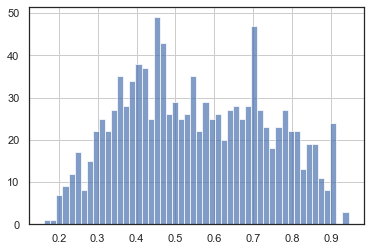

In [37]:
import seaborn as sns
sns.set(style="white")
plt.figure()
score_df['max_1'].hist(alpha=.7, bins=50)

<AxesSubplot:>

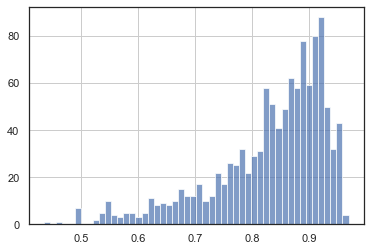

In [36]:
sns.set(style="white")
plt.figure()
score_df['max_3'].hist(alpha=.7, bins=50)

In [38]:
sm_df = sm_df.merge(score_df, how = 'left', left_index=True, right_index=True)

In [39]:
sm_df.to_csv(args.save_dir+'social_media_pred.csv', encoding='utf-8-sig')
score_df.to_csv(args.save_dir+'social_media_score.csv', encoding='utf-8-sig')

## END